# Import Required Libraries
Import the necessary libraries, including pandas, lime, and scikit-learn.

In [1]:
import lime
import lime.lime_tabular
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import random

In [ ]:
RANDOM_STATE = 42
NUM_CLASSES = 3
NUM_FEATURES = 4
TEST_SIZE = 0.2

# Load the Iris Dataset
Load the iris dataset using pandas and convert it to a DataFrame.

In [3]:
# Load the iris dataset using pandas and convert it to a DataFrame
iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['target'] = iris.target

# Split the data into features and target
X = df.drop(columns=['target'])
y = df['target']

# Split the Data into Training and Testing Sets
Use train_test_split to split the DataFrame into training and testing sets.

In [4]:
# Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# Train a RandomForestClassifier
Train a RandomForestClassifier using the training data.

In [5]:
N_ESTIMATORS = 100

In [6]:
# Train a RandomForestClassifier
rf = RandomForestClassifier(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# Calculate Feature Limits
Calculate the feature limits for plotting decision boundaries.

In [7]:
# Calculate Feature Limits
n_features = X.shape[1]

feature_means = {i: X.iloc[:, i].mean() for i in range(n_features)}
feature_limits = {}

BoundaryPadding = 1

for i in range(n_features - 1):
    for j in range(i, n_features):
        x_min = X.iloc[:, i].min() - BoundaryPadding
        x_max = X.iloc[:, i].max() + BoundaryPadding
        y_min = X.iloc[:, j].min() - BoundaryPadding
        y_max = X.iloc[:, j].max() + BoundaryPadding
        feature_limits[(i, j)] = (x_min, x_max, y_min, y_max)

# Function to Plot Decision Boundaries
Define a function to plot decision boundaries using the feature limits.

In [8]:
# Function to plot decision boundaries
def plot_decision_boundaries(ax, X, y, clf, feature_pair):
    # Create a mesh grid
    x_min, x_max, y_min, y_max = feature_limits[feature_pair]
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    # Predict on the mesh grid
    X_full = pd.DataFrame(np.zeros((xx.ravel().shape[0], X.shape[1])), columns=X.columns)
    X_full.iloc[:, feature_pair[0]] = xx.ravel()
    X_full.iloc[:, feature_pair[1]] = yy.ravel()
    for k in range(X.shape[1]):
        if k not in feature_pair:
            X_full.iloc[:, k] = feature_means[k]

    Z = clf.predict(X_full)
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    ax.contourf(xx, yy, Z, alpha=0.3)
    scatter = ax.scatter(
        X.iloc[:, feature_pair[0]], X.iloc[:, feature_pair[1]], c=y, edgecolor="k", marker="o"
    )
    ax.set_xlabel(iris.feature_names[feature_pair[0]])
    ax.set_ylabel(iris.feature_names[feature_pair[1]])
    ax.set_title(
        f"{iris.feature_names[feature_pair[0]]} vs {iris.feature_names[feature_pair[1]]}"
    )
    legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
    ax.add_artist(legend1)

# Function to Create a Grid of Decision Boundary Plots
Define a function to create a grid of decision boundary plots for the trained classifier.

In [9]:
# Function to create a grid of decision boundary plots
def plot_all_decision_boundaries(clf, X, y):
    n_features = X.shape[1]
    fig, axes = plt.subplots(n_features - 1, n_features - 1, figsize=(20, 20))

    for i in range(n_features - 1):
        for j in range(i + 1, n_features):
            if i < j:
                plot_decision_boundaries(axes[i, j - 1], X, y, clf, feature_pair=(i, j))
            else:
                axes[i, j - 1].axis("off")

    plt.tight_layout()
    return fig, axes

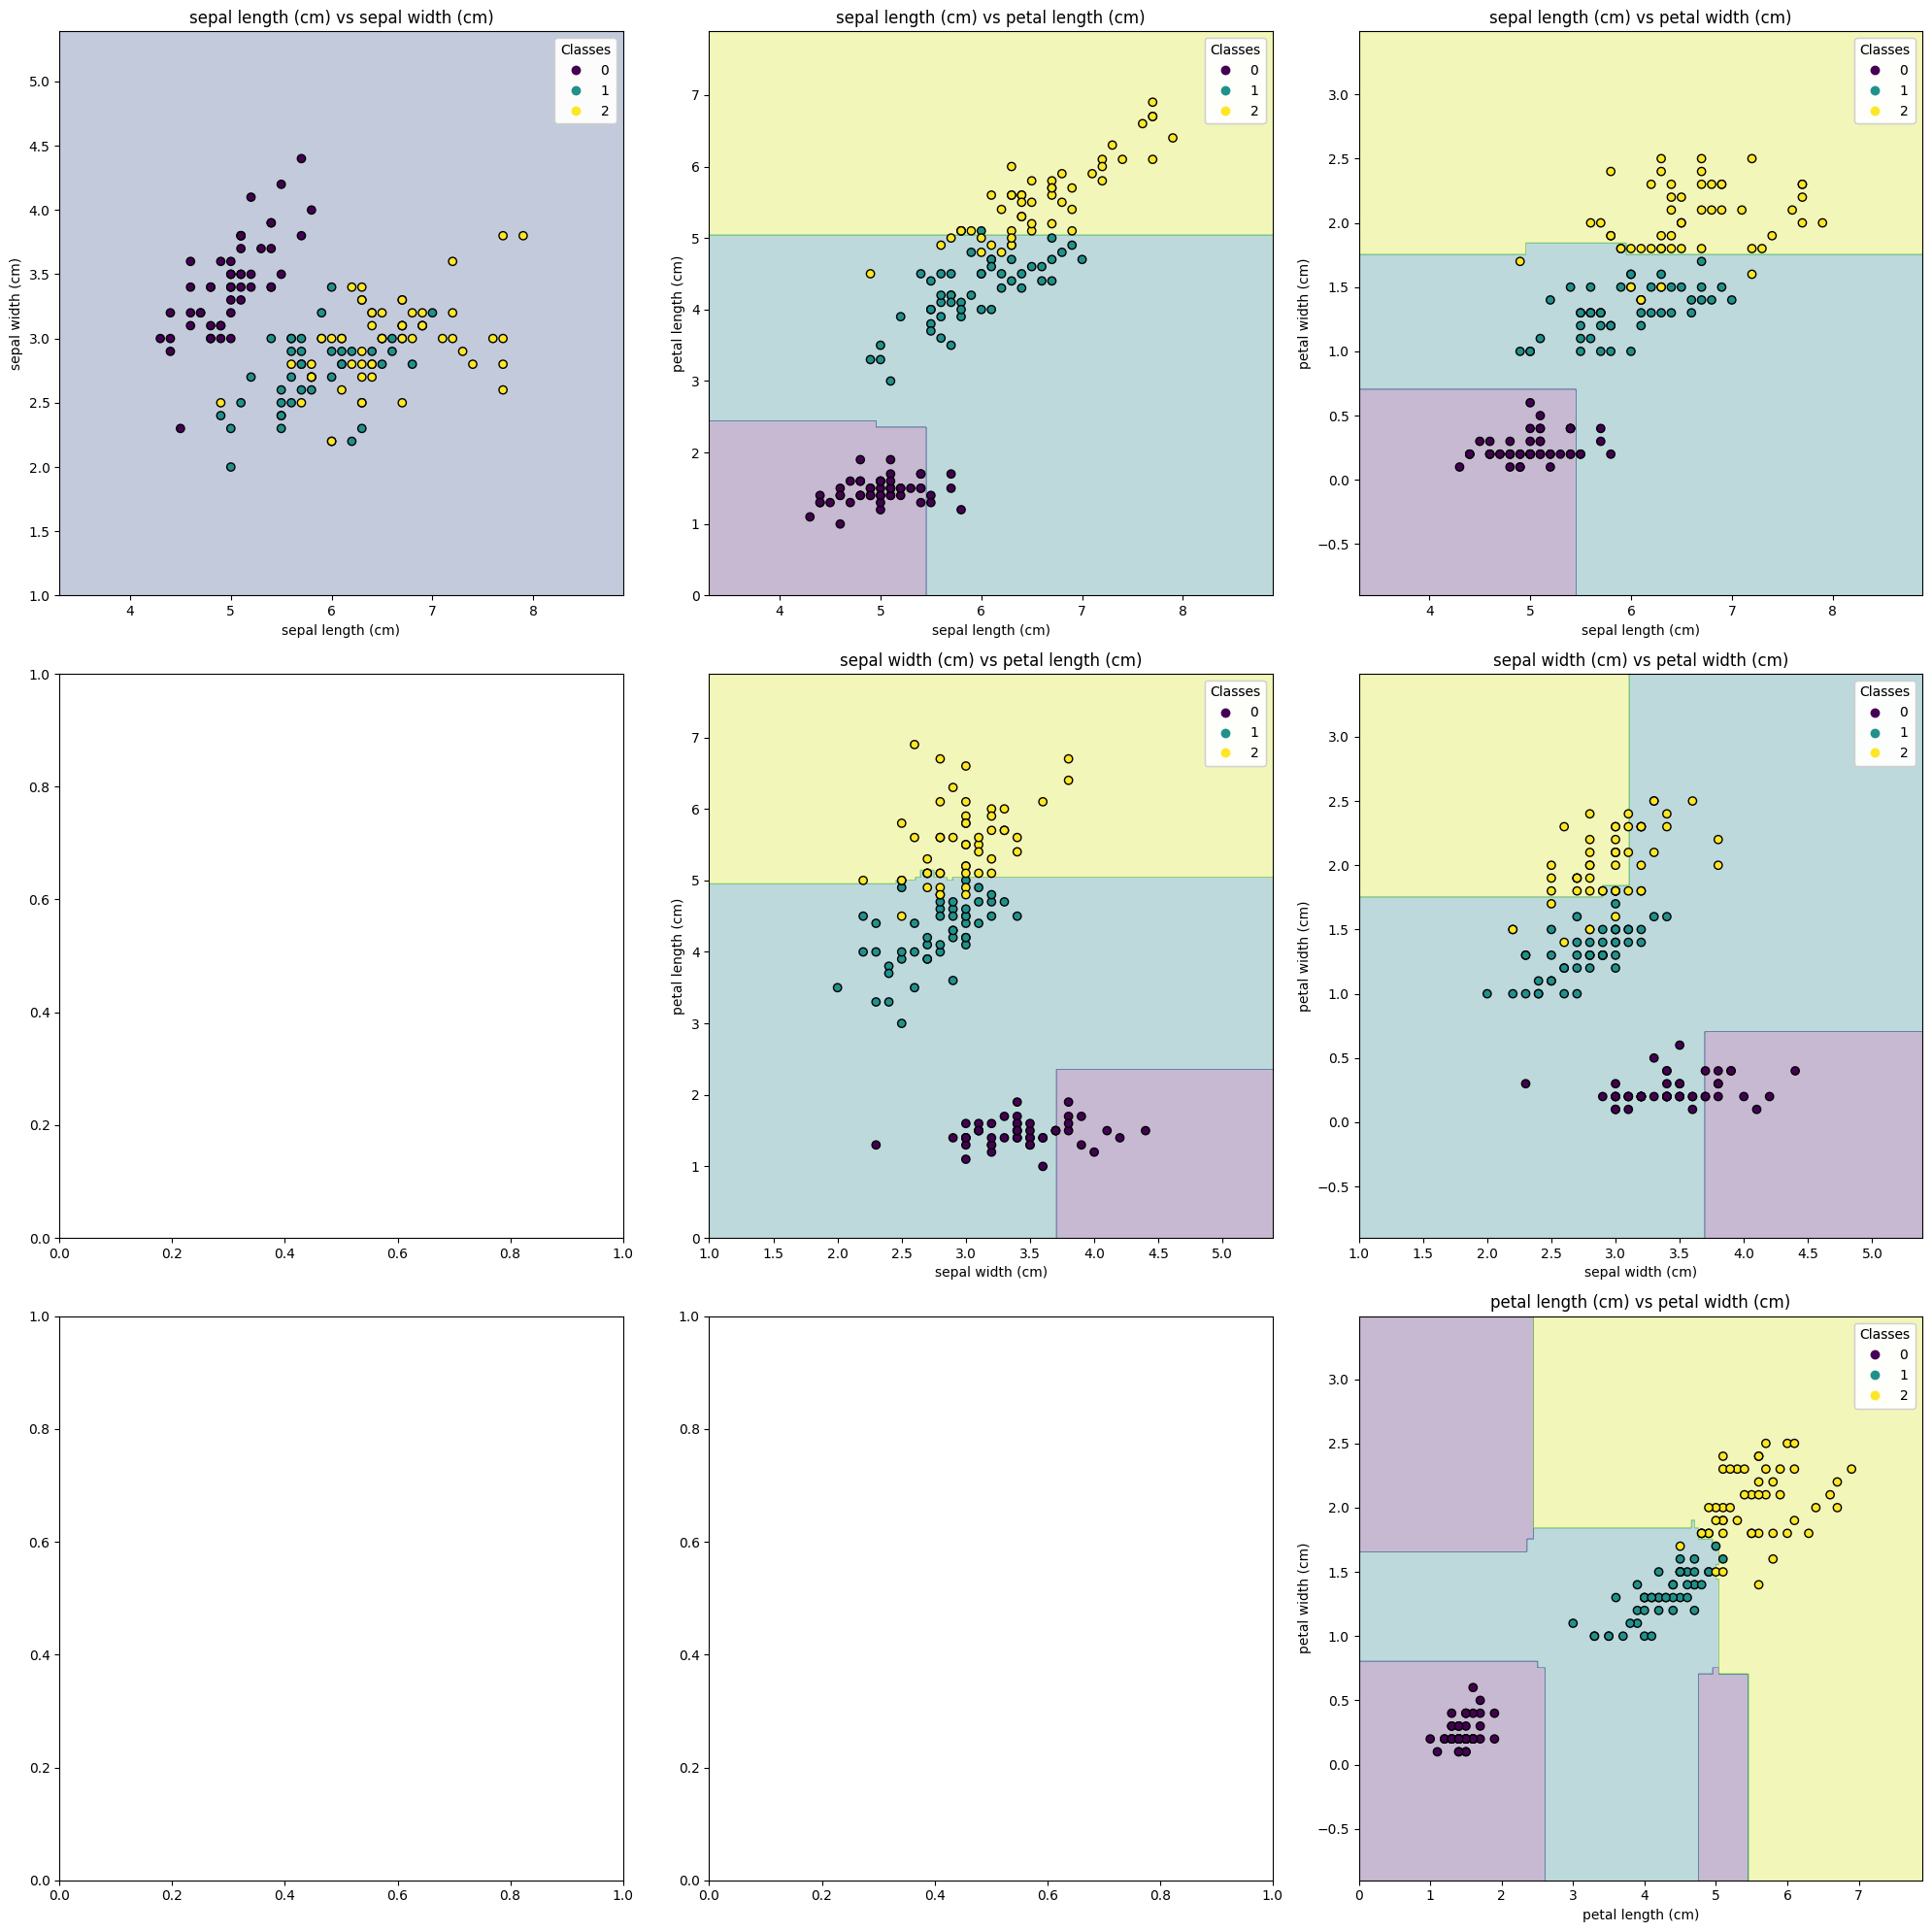

In [10]:
# Use the function to plot decision boundaries for the trained classifier
plot_all_decision_boundaries(rf, X, y);

# Choose an Instance to Explain
Choose a random instance from the test set to explain using LIME.

In [11]:
# Choose an instance to explain
instance_idx = 0#random.randint(0, X_test.shape[0] - 1)
instance_input = X_test.iloc[instance_idx]
instance_output = y_test.iloc[instance_idx]

# Create a LIME Explainer
Create a LIME explainer and generate an explanation for the chosen instance.

In [ ]:
# Create a LIME Explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    class_names=iris.target_names,
    discretize_continuous=True,
)

# Generate explanation
exp = explainer.explain_instance(
    instance_input.values, rf.predict_proba, num_features=4, top_labels=2
)

# Display the explanation
exp.show_in_notebook(show_table=True, show_all=True)

NameError: name 'lime' is not defined

In [ ]:
linear_models_list = []
for label in range(NUM_CLASSES):
    feature_index_to_name = {
        0: "sepal length (cm)",
        1: "sepal width (cm)",
        2: "petal length (cm)",
        3: "petal width (cm)",
    }
    linear_model_dict = {
        feature_index_to_name[key]: float(value) for key, value in exp.local_exp[label]
    }
    linear_model_dict["intercept"] = float(exp.intercept[label])
    linear_models_list.append(linear_model_dict)

In [ ]:
# Define a function to calculate the prediction score for a given instance
def predict_scores(instance, linear_models_lists):
    return_list = []
    for linear_model_dict in linear_models_lists:
        score = linear_model_dict["intercept"]
        for key, value in instance.items():
            score += linear_model_dict[key] * value
        return_list.append(score)
    return np.array(return_list)

In [ ]:
scores = predict_scores(instance_input, linear_models_list)
print(f"Class Scores: {scores}")
initial_class = int(scores.argmax())
print(f"Explainer Predicted Class: {initial_class}")

Class Scores: [-0.85580585  1.46778883  0.38801702]
Explainer Predicted Class: 1


In [16]:
from scipy.optimize import minimize

In [ ]:
# Define a loss function that ensures other scores are bigger than the initial highest score and penalizes the difference from the original instance
def loss_function(x, initial_input, linear_models_list, initial_class, target_class, regularization_strength=1.0):
    scores = predict_scores(x, linear_models_list)
    initial_class_predicted_score = scores[initial_class]
    target_class_score = scores[target_class]
    
    # Regularization term to penalize the difference from the original instance
    regularization_term = regularization_strength * np.sum((x - initial_input.values) ** 2)
    
    # Loss is the difference between the max other score and the initial score plus the regularization term
    loss = target_class_score - initial_class_predicted_score + regularization_term
    return loss

# Use an optimization algorithm to minimize the loss function
def find_least_change(instance_input, linear_models_list, initial_class, regularization_strength=1.0):
    x0 = instance_input.copy()
    inital_input = instance_input.copy()
    result = minimize(loss_function, x0, args=(inital_input, linear_models_list, initial_class, regularization_strength), method='BFGS')
    return result.x

# Example usage
new_instance_values = find_least_change(instance_input,  initial_class)
new_instance = instance_input.copy()  # Create a copy of the original instance
new_instance[:] = new_instance_values  # Update the copy with optimized values

print("Original instance:")
print(instance_input)
print("Modified instance to change class:")
print(new_instance)

NameError: name 'coefficients' is not defined